#1 Gerekli Kütüphaneleri import edelim

In [ ]:
import numpy as np # lineer Cebir
import pandas as pd # cvs dosyalarını okumak için 
import matplotlib.pyplot as plt
import os,fnmatch
import librosa
import IPython.display as ipd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
d_yolu=["/content/gdrive/MyDrive/My/data/"]

##2 Bölüm Mel-FC Göre öznitelik çıkarma

In [ ]:
# DataFrame sutunlarını belirleyelim.
sutunlar=["mfkk"+str(i) for i in range(20)]
for isim in ["zero","centroid","rolloff","chroma","class","dosya"]:
    sutunlar.append(isim)

In [ ]:
classes_liste=["Ali*.wav","Arzu*.wav","Dilek*.wav","elif*.wav","Reyyan*.wav","Zeliha*.wav"]

In [ ]:
# burdaki maksat verilen ses dosyaları mel-frekans özelliklerine göre hesaplamamk
def ses_df(d_yolu,sutunlar,classes_liste):
    liste=[]
    adim=0
    for folder in d_yolu:
        for classes in classes_liste:          
            dosyalar=fnmatch.filter(os.listdir(folder),classes)
            label=classes.split("*")[0]
            for dosya in dosyalar:
                x,sr=librosa.load(folder+dosya,duration=5,res_type='kaiser_fast') # kayıt kalitesi yüksek olsun
                liste.append([np.mean(x) for x in librosa.feature.mfcc(x,sr=sr)])
                #mel frekans özelliklerine göre tek tek hesaplıyoruz
                liste[adim].append(sum(librosa.zero_crossings(x)))
                liste[adim].append(np.mean(librosa.feature.spectral_centroid(x)))
                liste[adim].append(np.mean(librosa.feature.spectral_rolloff(x,sr=sr)))
                liste[adim].append(np.mean(librosa.feature.chroma_stft(x,sr=sr)))
                liste[adim].append(label)
                liste[adim].append(dosya)
                adim+=1
    return pd.DataFrame(liste,columns=sutunlar)

In [ ]:
sound_df=ses_df(d_yolu,sutunlar,classes_liste)  # veri seti paketleri okunur

3 dakikaya yakın okuma süresi

300 kayıt okundu ve 26 öznitelik çıkartıldı

In [ ]:
sound_df.shape # veri seti boyutu 

(300, 26)

In [ ]:
sound_df.head(10) # baştan verilen sayı kadar eleman göster

,mfkk0,mfkk1,mfkk2,mfkk3,mfkk4,mfkk5,mfkk6,mfkk7,mfkk8,mfkk9,mfkk10,mfkk11,mfkk12,mfkk13,mfkk14,mfkk15,mfkk16,mfkk17,mfkk18,mfkk19,zero,centroid,rolloff,chroma,class,dosya
0,-355.954346,169.742889,-19.902596,28.418028,-1.920642,14.963635,-18.042419,-8.990522,-9.575677,0.247181,2.559003,-16.274439,-0.461128,-5.526151,-1.625946,-4.318705,-8.277762,-5.616351,-7.864811,-7.296755,8520,1265.504775,2290.494792,0.417955,Ali,Ali_3.wav
1,-447.095642,178.927063,12.228930,37.981197,-24.036402,13.025295,-0.333844,-6.965903,-3.214724,-3.361969,3.558750,-7.063427,-3.945463,0.347602,-1.328662,-2.812511,-4.274102,-3.536934,-2.224093,-2.675308,5684,1020.674096,1945.365397,0.473595,Ali,Ali_1.wav
2,-364.826904,169.976303,-21.874685,9.795225,-13.977684,8.645334,-8.288508,-15.337212,-0.715504,-3.870763,-3.599646,-10.332271,1.933615,6.916882,-5.657340,-11.266426,-4.222750,-3.444461,-7.300763,-2.356554,8351,1192.465212,2084.483846,0.383786,Ali,Ali_2.wav
3,-367.243408,170.081024,-15.345336,34.885860,-12.447840,3.041697,-0.621050,-4.420214,-6.975327,-3.461966,-0.012565,-13.028275,5.872286,-1.722359,-9.558955,4.707227,-5.332635,-4.391449,-1.594229,-4.945591,6528,1145.346859,2237.509155,0.486433,Ali,Ali_4.wav
4,-361.912903,128.821594,-11.965178,26.840284,-6.864795,-13.950869,-19.378523,-5.910888,-14.366224,-0.273743,-7.436700,-11.424229,1.212049,-11.860926,-3.683819,-8.784780,-5.947865,-1.461356,-10.697935,-5.175135,9824,1433.281838,2674.104818,0.401804,Ali,Ali_5.wav
5,-302.772766,146.701935,-17.620735,-7.483420,-16.407589,13.784188,-28.873062,4.154629,-21.541224,-8.092579,9.522039,-24.325977,-2.182134,-1.790538,0.899837,-6.698143,-9.004281,4.118487,-8.072216,-5.159385,9264,1429.069085,2371.643066,0.389306,Ali,Ali_9.wav
6,-357.739105,146.673065,13.708347,9.823106,-17.629517,21.162594,-16.493515,-16.921360,-5.898714,-8.108835,7.538182,-13.397186,-3.126076,0.321626,-4.458877,-4.317242,-13.786483,-3.111623,-2.531256,-6.747624,7886,1230.049134,2217.421468,0.385245,Ali,Ali_6.wav
7,-429.777557,170.654404,36.894497,27.503572,-14.648817,16.274246,-5.880689,-5.642463,-8.726011,-13.013259,-4.677045,-18.139292,3.186763,-0.936723,-4.197371,2.091498,-8.416356,-3.408891,-10.758715,-9.921914,4712,872.349720,1539.275106,0.354978,Ali,Ali_8.wav
8,-344.779633,172.349747,-17.463160,32.318851,-13.112624,1.904238,-4.058469,0.042022,-28.500183,-12.621312,12.278326,-18.138796,0.106847,-1.391799,-11.714125,-1.085619,-5.609702,-10.814443,-7.317196,-1.849419,7532,1190.136925,2203.165690,0.372732,Ali,Ali_7.wav
9,-294.543671,121.838654,-0.601201,37.885292,-9.610444,5.730218,-20.219051,-8.254992,-22.560469,-12.159062,9.410575,-9.775681,-3.100754,-7.988059,-7.502536,-2.292513,-8.935316,-2.987731,-7.161915,-5.173779,10967,1651.616710,3128.694661,0.404863,Ali,Ali_10.wav


In [ ]:
sound_df["class"].value_counts() # sınıflardaki verilerin ne kadar olduğunu görüyoruz

Zeliha    50
Reyyan    50
elif      50
Ali       50
Dilek     50
Arzu      50
Name: class, dtype: int64

In [ ]:
X=sound_df.iloc[:,0:5] # o aralıktaki satır boyu kadar olacak kısımlara kadar olan bilgiyi görüntüle
y=sound_df["class"]
y

0         Ali
1         Ali
2         Ali
3         Ali
4         Ali
        ...  
295    Zeliha
296    Zeliha
297    Zeliha
298    Zeliha
299    Zeliha
Name: class, Length: 300, dtype: object

#**3- Eğitim ve Test Kümelerini Oluşturma.**

In [ ]:
random_state = np.random.RandomState(31) #rastgele verilerin gelmesi için   (0 ile 2**32 - 1 )

In [ ]:
#Train ve Test olmak üzere oluşturduğumuz öznitelik verisini bölüyoruz.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=random_state)
print("X Train: ",len(X_train),"\n","X Test: ",len(X_test),sep="")

X Train: 240
X Test: 60



#**4- Random Forest Sınıflandırma.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(
 max_depth=8,#Ağacın maksimum derinliği.
 max_features=5, #En iyi bölünmeyi ararken göz önünde bulundurulması gereken özelliklerin sayısı
 min_samples_split=5,# dahili düğümü bölmek için gereken minimum örnek sayısı
 n_estimators=500).fit(X_train,y_train)  #n_estimators Ormandaki ağaç sayısı.

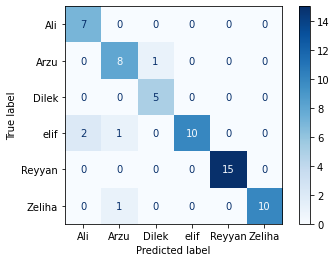

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred=forest.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
###-------------------------------- Random Forest ------------------------------------##
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,labels=forest.classes_, target_names=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"]))

              precision    recall  f1-score   support

         Ali       0.78      1.00      0.88         7
        Arzu       0.80      0.89      0.84         9
       Dilek       0.71      1.00      0.83         5
        elif       1.00      0.77      0.87        13
      Reyyan       1.00      1.00      1.00        15
      Zeliha       1.00      0.82      0.90        11

    accuracy                           0.90        60
   macro avg       0.88      0.91      0.89        60
weighted avg       0.92      0.90      0.90        60



## K-Folds Cross Validation:
1-Random Forest

In [ ]:
# Random Forest k-fold cross validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(forest,X,y,cv=10))

[0.93333333 0.96666667 0.96666667 0.93333333 0.96666667 0.93333333
 0.86666667 0.93333333 0.83333333 0.86666667]


In [ ]:
# Random Forest k-fold cross validation başarı oranı
accuaries=cross_val_score(estimator=forest, X=X_train, y=y_train,cv=10)
print("Accuracy (mean): %",accuaries.mean()*100)
print("standart: %",accuaries.std()*100)

Accuracy (mean): % 95.00000000000001
standart: % 4.487637339278753


#**5- SVM sınıflandırma.**

POLİNOMAL MODEL

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_train)
# yöntemin daha optimize sonuç vermesi için
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
kernel_poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train_scaled, y_train)# hyper parameterler sayesinde sınıflandırma başarı oranını arttırdık

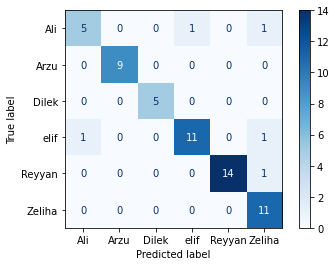

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = kernel_poly.predict(X_test_scaled)
cm = confusion_matrix(y_test, predictions, labels=kernel_poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
###-------------------------------- POLİNOMAL ------------------------------------##
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"]))

              precision    recall  f1-score   support

         Ali       0.83      0.71      0.77         7
        Arzu       1.00      1.00      1.00         9
       Dilek       1.00      1.00      1.00         5
        elif       0.92      0.85      0.88        13
      Reyyan       1.00      0.93      0.97        15
      Zeliha       0.79      1.00      0.88        11

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



## K-Folds Cross Validation:
1-SVM -POLİNOMAL MODEL

In [ ]:
# Polinomal model k-fold cross validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(kernel_poly,X,y,cv=10))

[0.36666667 0.46666667 0.4        0.3        0.4        0.3
 0.3        0.4        0.3        0.33333333]


In [ ]:
# Polinomal model k-fold cross validation başarı oranı
accuaries_poly=cross_val_score(estimator=kernel_poly, X=X_train_scaled, y=y_train,cv=10)
print("Accuracy (mean): %",accuaries_poly.mean()*100)
print("standart: %",accuaries.std()*100)

Accuracy (mean): % 90.0
standart: % 4.487637339278753


RBF MODEL

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled_rbf=scaler.transform(X_train)
X_test_scaled_rbf=scaler.transform(X_test)

In [ ]:
RBF_model = svm.SVC(kernel='rbf', random_state=random_state).fit(X_train_scaled_rbf, y_train)
## parametreler ile iyileştirme yap!

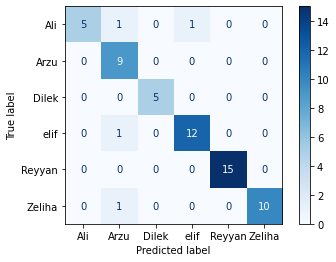

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions_rbf = RBF_model.predict(X_test_scaled_rbf)
rbf = confusion_matrix(y_test, predictions_rbf, labels=RBF_model.classes_)
disp_rbf = ConfusionMatrixDisplay(confusion_matrix=rbf,display_labels=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"])
disp_rbf.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
###-------------------------------- RBF ------------------------------------##
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_rbf, target_names=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"]))

              precision    recall  f1-score   support

         Ali       1.00      0.71      0.83         7
        Arzu       0.75      1.00      0.86         9
       Dilek       1.00      1.00      1.00         5
        elif       0.92      0.92      0.92        13
      Reyyan       1.00      1.00      1.00        15
      Zeliha       1.00      0.91      0.95        11

    accuracy                           0.93        60
   macro avg       0.95      0.92      0.93        60
weighted avg       0.95      0.93      0.93        60



## K-Folds Cross Validation:
1-SVM -RBF MODEL

In [ ]:
# RBF model k-fold cross validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(RBF_model,X,y,cv=10))

[0.36666667 0.46666667 0.4        0.4        0.36666667 0.23333333
 0.3        0.4        0.23333333 0.36666667]


In [ ]:
# RBF model k-fold cross validation başarı oranı
accuaries_rbf=cross_val_score(estimator=RBF_model, X=X_train_scaled_rbf, y=y_train,cv=10)
print("Accuracy (mean): %",accuaries_rbf.mean()*100)
print("standart: %",accuaries_rbf.std()*100)

Accuracy (mean): % 97.50000000000001
standart: % 2.7638539919628333


 LİNEAR MODEL

In [ ]:
from sklearn.svm import SVC
linear_model =SVC(random_state=random_state)
#################################################  LINEAR MODEL #########################
linear_model = SVC(kernel='linear')
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

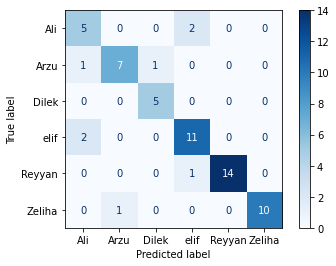

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
SVC(random_state=random_state)
predictions_linear = linear_model.predict(X_test)
linear = confusion_matrix(y_test, predictions_linear,labels=linear_model.classes_)
disp_linear = ConfusionMatrixDisplay(confusion_matrix=linear, display_labels=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"])
disp_linear.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
###-------------------------------- LİNEAR ------------------------------------##
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_linear, target_names=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"]))

              precision    recall  f1-score   support

         Ali       0.62      0.71      0.67         7
        Arzu       0.88      0.78      0.82         9
       Dilek       0.83      1.00      0.91         5
        elif       0.79      0.85      0.81        13
      Reyyan       1.00      0.93      0.97        15
      Zeliha       1.00      0.91      0.95        11

    accuracy                           0.87        60
   macro avg       0.85      0.86      0.86        60
weighted avg       0.88      0.87      0.87        60



## K-Folds Cross Validation:
1-SVM -LİNEAR MODEL

In [ ]:
# Linear model k-fold cross validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(linear_model,X,y,cv=10))

[0.86666667 0.9        0.96666667 0.83333333 0.93333333 0.96666667
 0.8        0.9        0.8        0.76666667]


In [ ]:
# Linear model k-fold cross validation başarı oranı
accuaries_linear=cross_val_score(estimator=linear_model, X=X_train, y=y_train,cv=10)
print("Accuracy (mean): % ",accuaries_linear.mean()*100)
print("standart: % ",accuaries_linear.std()*100)

Accuracy (mean): %  94.16666666666667
standart: %  5.0


#**6- Diğer Sınıflandırma Yöntemleri.**
   1 - DecisionTreeClassifier
   2 - VotingClassifier
   3 - KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

KNN=KNeighborsClassifier(n_neighbors = 4) 
dt = DecisionTreeClassifier(criterion='gini', max_depth= 6, min_samples_leaf = 1)
classifiers = [
('K-Neighbors', KNN),
('Decision Tree', dt) 
]
for name, model in classifiers: 
     model.fit(X_train, y_train) 
     y_pred_classifer = model.predict(X_test) 
     acc = accuracy_score(y_test, y_pred_classifer) 
     print(name ,': %', acc)

K-Neighbors : % 0.36666666666666664
Decision Tree : % 0.7666666666666667


#Voting Classifier

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_train)
#puanlama algoritması optimize edilince daha iyi çalışmaktadır
X_train_scaled_vc=scaler.transform(X_train)
X_test_scaled_vc=scaler.transform(X_test)

In [ ]:
vc = VotingClassifier(estimators = classifiers, voting = 'soft')
vc.fit(X_train_scaled_vc, y_train)
y_pred = vc.predict(X_test_scaled_vc)
vc_acc = accuracy_score(y_test, y_pred)
print('Voting Classifier: %',vc_acc)

Voting Classifier: % 0.8


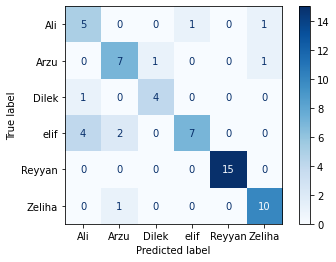

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions_classifiers_VC= vc.predict(X_test_scaled_vc)
classifiersx_cV= confusion_matrix(y_test, predictions_classifiers_VC,labels=vc.classes_)
disp_classifiersx_VC= ConfusionMatrixDisplay(confusion_matrix=classifiersx_cV, display_labels=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"])
disp_classifiersx_VC.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
###-------------------------------- Voting Classifier ------------------------------------##
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_classifiers_VC, target_names=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"]))

              precision    recall  f1-score   support

         Ali       0.50      0.71      0.59         7
        Arzu       0.70      0.78      0.74         9
       Dilek       0.80      0.80      0.80         5
        elif       0.88      0.54      0.67        13
      Reyyan       1.00      1.00      1.00        15
      Zeliha       0.83      0.91      0.87        11

    accuracy                           0.80        60
   macro avg       0.78      0.79      0.78        60
weighted avg       0.82      0.80      0.80        60



#**Decision Tree Confux-Matrix.**

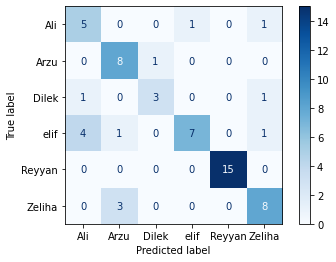

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions_classifiers_dc= dt.predict(X_test)
classifiersx = confusion_matrix(y_test, predictions_classifiers_dc,labels=dt.classes_)
disp_classifiersx = ConfusionMatrixDisplay(confusion_matrix=classifiersx, display_labels=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"])
disp_classifiersx.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
###-------------------------------- Decision Tree ------------------------------------##
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_classifiers_dc, target_names=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"]))

              precision    recall  f1-score   support

         Ali       0.50      0.71      0.59         7
        Arzu       0.67      0.89      0.76         9
       Dilek       0.75      0.60      0.67         5
        elif       0.88      0.54      0.67        13
      Reyyan       1.00      1.00      1.00        15
      Zeliha       0.73      0.73      0.73        11

    accuracy                           0.77        60
   macro avg       0.75      0.74      0.74        60
weighted avg       0.79      0.77      0.77        60



## Decision Tree model K-Folds Cross Validation:



In [ ]:
# Decision Tree model k-fold cross validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(dt,X,y,cv=10))

[0.83333333 0.7        0.83333333 0.83333333 0.76666667 0.96666667
 0.86666667 0.8        0.7        0.76666667]


In [ ]:
# Decision Tree model k-fold cross validation başarı oranı
accuaries_dt=cross_val_score(estimator=dt, X=X_train, y=y_train,cv=10)
print("Accuracy (mean): %",accuaries_dt.mean()*100)
print("standart: %",accuaries_dt.std()*100)  

Accuracy (mean): % 80.83333333333333
standart: % 5.651941652604389


#**KNN Confux-Matrix.**

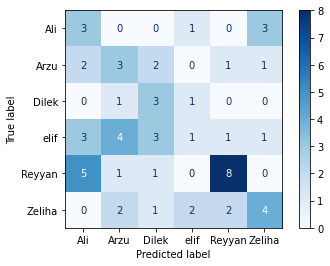

In [ ]:
#----------------------  KNN --------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions_classifiers_knn= KNN.predict(X_test)
classifiersx_knn = confusion_matrix(y_test, predictions_classifiers_knn,labels=KNN.classes_)
disp_classifiersx_knn = ConfusionMatrixDisplay(confusion_matrix=classifiersx_knn, display_labels=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"])
disp_classifiersx_knn.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
###-------------------------------- KNN ------------------------------------##
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_classifiers_knn, target_names=["Ali","Arzu","Dilek","elif","Reyyan","Zeliha"]))

              precision    recall  f1-score   support

         Ali       0.23      0.43      0.30         7
        Arzu       0.27      0.33      0.30         9
       Dilek       0.30      0.60      0.40         5
        elif       0.20      0.08      0.11        13
      Reyyan       0.67      0.53      0.59        15
      Zeliha       0.44      0.36      0.40        11

    accuracy                           0.37        60
   macro avg       0.35      0.39      0.35        60
weighted avg       0.38      0.37      0.36        60



## KNN model K-Folds Cross Validation:


In [ ]:
# KNN model k-fold cross validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(KNN,X,y,cv=10))

[0.43333333 0.46666667 0.5        0.46666667 0.46666667 0.4
 0.23333333 0.46666667 0.26666667 0.3       ]


In [ ]:
# KNN model k-fold cross validation başarı oranı
accuaries_KNN=cross_val_score(estimator=KNN, X=X_train, y=y_train,cv=10)
print("Accuracy (mean): %",accuaries_KNN.mean()*100)
print("standart: %",accuaries_KNN.std()*100)  

Accuracy (mean): % 36.25
standart: % 4.583333333333334
